In [11]:
%matplotlib inline

import os
import sys
import datacube
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import xarray as xr
from odc.ui import with_ui_cbk
import pandas as pd

sys.path.append("Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser
from dea_plotting import rgb
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

In [12]:
dc = datacube.Datacube(app="Triangle_analysis")

In [13]:
# setting up the required latitude and longitude that will match up with the monash paper for validation
lat = (-34,-34.5)
lon = (145,145.5)

# defining a similar period of time for the same purpose
time = ("2010-01-17","2010-02-22")

In [14]:
display_map(x=lon,y=lat)

In [27]:
# loading the specified data for this time period

query = {
    'x': lon,
    'y': lat,
    'time': time,
    'measurements': [
        'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1',
        'nbart_swir_2', 'nbart_panchromatic'
    ],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

triangle = load_ard(dc=dc, products = ['ga_ls7e_ard_3'], **query)

Loading ga_ls7e_ard_3 data
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 2 observations 


In [28]:
print(triangle)

<xarray.Dataset>
Dimensions:             (time: 2, x: 1713, y: 2007)
Coordinates:
  * y                   (y) float64 -3.771e+06 -3.771e+06 ... -3.832e+06
  * x                   (x) float64 1.187e+06 1.187e+06 ... 1.238e+06 1.238e+06
  * time                (time) datetime64[ns] 2010-02-03T00:00:36.557060 2010-02-19T00:00:23.284239
Data variables:
    nbart_blue          (time, y, x) float32 nan nan nan ... 804.0 804.0 784.0
    nbart_green         (time, y, x) float32 nan nan nan ... 1181.0 1158.0
    nbart_red           (time, y, x) float32 nan nan nan ... 1581.0 1560.0
    nbart_nir           (time, y, x) float32 nan nan nan ... 2182.0 2179.0
    nbart_swir_1        (time, y, x) float32 nan nan nan ... 3275.0 3221.0
    nbart_swir_2        (time, y, x) float32 nan nan nan ... 2559.0 2529.0
    nbart_panchromatic  (time, y, x) float32 nan nan nan ... 1761.0 1629.0
Attributes:
    crs:      EPSG:3577


In [29]:
# creating the ndvi section fo the triangle database

triangle["ndvi"]=(triangle.nbart_nir-triangle.nbart_red)/(triangle.nbart_nir+triangle.nbart_red)

In [31]:
triangle = triangle.where(~triangle.isnull(),0)

In [32]:
print(triangle)

<xarray.Dataset>
Dimensions:             (time: 2, x: 1713, y: 2007)
Coordinates:
  * y                   (y) float64 -3.771e+06 -3.771e+06 ... -3.832e+06
  * x                   (x) float64 1.187e+06 1.187e+06 ... 1.238e+06 1.238e+06
  * time                (time) datetime64[ns] 2010-02-03T00:00:36.557060 2010-02-19T00:00:23.284239
Data variables:
    nbart_blue          (time, y, x) float32 0.0 0.0 0.0 ... 804.0 804.0 784.0
    nbart_green         (time, y, x) float32 0.0 0.0 0.0 ... 1181.0 1158.0
    nbart_red           (time, y, x) float32 0.0 0.0 0.0 ... 1581.0 1560.0
    nbart_nir           (time, y, x) float32 0.0 0.0 0.0 ... 2182.0 2179.0
    nbart_swir_1        (time, y, x) float32 0.0 0.0 0.0 ... 3275.0 3221.0
    nbart_swir_2        (time, y, x) float32 0.0 0.0 0.0 ... 2559.0 2529.0
    nbart_panchromatic  (time, y, x) float32 0.0 0.0 0.0 ... 1761.0 1629.0
    ndvi                (time, y, x) float32 0.0 0.0 0.0 ... 0.159713 0.16555229
Attributes:
    crs:      EPSG:3577


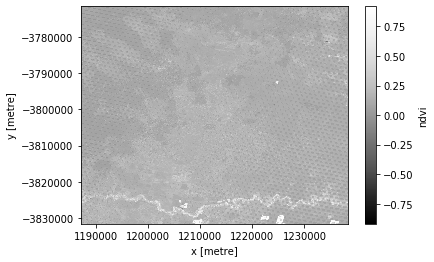

In [36]:
# averaging the ndvi over the time period specified

ave_NDVI = triangle.ndvi.mean(dim="time")

# plotting the average 

ave_NDVI.plot(cmap="Greys_r")
plt.show()